In [1]:
#!/usr/bin/env python

#%%

"""
These functions implement the SE2 Lie Group see (http://ethaneade.com/lie.pdf)
"""

import numpy as np
import matplotlib.pyplot as plt

def SE2_log(M):
    """
    Matrix logarithm for SE2 Lie group
    """
    theta = np.arctan2(M[1, 0], M[0, 0])
    if np.abs(theta) < 1e-6:
        A = 1 - theta**2/6 + theta**4/120
        B = theta/2 - theta**3/24 + theta**5/720
    else:
        A = np.sin(theta)/theta
        B = (1 - np.cos(theta))/theta
    V_inv = np.array([[A, B], [-B, A]])/(A**2 + B**2)
    t = M[:2, 2]
    u = V_inv.dot(t)
    return np.array([theta, u[0], u[1]])

def SE2_from_param(v):
    """
    Create SE2 from paramters, [theta, x, y]
    """
    theta, x, y = v
    return np.array([
        [np.cos(theta), -np.sin(theta), x],
        [np.sin(theta), np.cos(theta), y],
        [0, 0, 1]
    ])

def SE2_to_param(M):
    """
    From matrix to [theta, x, y]
    """
    theta = np.arctan2(M[1, 0], M[0, 0])
    x = M[0, 2]
    y = M[1, 2]
    return np.array([theta, x, y])

def SE2_inv(M):
    """
    SE2 inverse
    """
    R = M[:2, :2]
    t = np.array([M[:2, 2]]).T
    return np.block([
        [R.T, -R.T.dot(t)],
        [0, 0, 1]
    ])

def SE2_exp(v):
    """
    SE2 matrix exponential
    """
    theta, x, y = v
    if np.abs(theta) < 1e-6:
        A = 1 - theta**2/6 + theta**4/120
        B = theta/2 - theta**3/24 + theta**5/720
    else:
        A = np.sin(theta)/theta
        B = (1 - np.cos(theta))/theta
    V = np.array([[A, -B], [B, A]])
    R = np.array([
        [np.cos(theta), -np.sin(theta)],
        [np.sin(theta), np.cos(theta)]])
    u = np.array([[x, y]]).T
    return np.block([
        [R, V.dot(u)],
        [0, 0,  1]])

def test_SE2():
    v = np.random.randn(3)
    X = SE2_from_param(v)
    assert np.allclose(X.dot(SE2_inv(X)), np.eye(3))
    assert np.allclose(SE2_log(SE2_exp(v)) - v, np.zeros(3))
    assert np.allclose(SE2_to_param(SE2_from_param(v)) - v, np.zeros(3))

    v = np.zeros(3)
    X = SE2_from_param(v)
    assert np.allclose(X.dot(SE2_inv(X)), np.eye(3))
    assert np.allclose(SE2_log(SE2_exp(v)) - v, np.zeros(3))
    assert np.allclose(SE2_to_param(SE2_from_param(v)) - v, np.zeros(3))

def sample(X_goal, box):
    """
    Sample from planning area [10, 10], [-5, 5],
    with 10% probability, return X_goal

    @param X_goal: The goal position
    @param box: [xmin, xmax, ymin, ymax]

    @return: (sample, is_goal) (bool)
    """
    if np.random.rand() < 0.1:
        return X_goal, True
    else:
        xmin, xmax, ymin, ymax = box
        x = xmin + (xmax - xmin)*np.random.rand()
        y = ymin + (ymax - ymin)*np.random.rand()
        theta = 2*np.pi*np.random.rand()
        XS = SE2_from_param([theta, x, y])

        # if close to goal in euclidean distance, set to goal
        theta_g, x_g, y_g = SE2_to_param(X_goal)
        d = np.sqrt((x - x_g)**2 + (y - y_g)**2)
        if d < 1:
            return X_goal, True
        else:
            return XS, False

def find_u_R_d(X0, X1):
    """
    Compute arch length, radius, and euclidean distance
    """
    dtheta, dx, dy = SE2_to_param(SE2_inv(X0).dot(X1))
    d = np.sqrt(dx**2 + dy**2)
    alpha = np.arctan2(dy, dx)
    if np.abs(alpha) > 1e-3:
        R = d/(2*np.sin(alpha))
        u = R*2*alpha
    else:
        R = np.infty
        u = d
    
    return u, R, d

def distance(X0, X1):
    """
    Compute the distance from X0 to X1. There
    is a higher weight placed on cross-track movement (dy),
    as this is harder for the vehicle than turning (dtheta)
    and formward movingment (dx)
    """
    u, R, d = find_u_R_d(X0, X1)
    cost = np.abs(u)
    # don't allow min turn radius if not extremely close
    if d > 0.1 and np.abs(R) < 0.5:
        cost = np.infty
    # don't allow backing up
    if u < 0:
        cost = np.infty
    return cost

def local_path_planner(X0, X1, dist):
    """
    Plan a path from X0 to X1. If the norm of the lie algebra
    is greather than 1, limit it to 1.

    @para X0: start
    @param X1: goal
    @dist: the distance to travel
    """
    u, R, d = find_u_R_d(X0, X1)
    print('u', u)
    print('dist', dist)
    if np.abs(u) > dist:
        u = dist*np.sign(u)
    print(R)
    print(np.abs(R))
    if np.abs(R) < 1e-3:
        omega = 0
    else:
        omega = u/R
    v = np.array([omega, u, 0])
    print('v', v)
    print('V', SE2_exp(v))
    print(X0.dot(SE2_exp(v)))
    return X0.dot(SE2_exp(v))

def collision(collision_points, vehicle_radius, X0, X1, box, steps):
    """
    Check that the points along the trajectory from X0 to
    X1 do not collide with the circular collision points defined
    as a list of [x, y, r], where (x, y) is the center, and
    r is the radius. Evaluate the trajectory at (steps) discrete
    points.

    @param collision_points: list of [x, y, radius]
    @param vehicle_radius: radius of vehicle
    @param X0: start point
    @param X1: end point
    @param box: [xmin, xmax, ymin, ymax]
    @param steps: number of steps along trajectory
    """
    v = SE2_log(SE2_inv(X0).dot(X1))
    for t in np.linspace(0, 1, steps):
        X = X0.dot(SE2_exp(v*t))
        theta, x, y = SE2_to_param(X)
        # check bounds of environment
        rv = vehicle_radius
        if (x < box[0] + rv or x > box[1] - rv or y < box[2] + rv or y > box[3] - rv):
            return True
        for xc, yc, r in collision_points:
            if (xc - x)**2 + (yc - y)**2 < (r + rv)**2:
                return True
    return False

class Tree:
    """
    This is a tree data structure that is used for RRT.
    Each tree has one parent, and a list of children.
    """

    def __init__(self, position):
        self.position = position
        self.parent = None
        self.children = []

    def add(self, child):
        """
        Add the child node to the tree.
        """
        child.parent = self
        self.children.append(child)

    def closest(self, position, black_list):
        """
        Find the node closest to the given position.

        @param position to get closest to
        @param black_list: black list of children to ignore
         (so can avoid duplicate collision checks)
        """
        closest_node = self
        if self in black_list:
            dist_min = np.infty
        else:
            dist_min = distance(self.position, position)
        for child in self.children:
            child_closest, dist_child = child.closest(position, black_list)
            if dist_child < dist_min:
                closest_node = child_closest
                dist_min = dist_child
        return closest_node, dist_min

    def get_leaves(self):
        """store_true
        Get all nodes (leaves) in the tree.
        """
        leaves = [self]
        for child in self.children:
            leaves.extend(child.get_leaves())
        return leaves

    def path(self):
        """
        Find the path from the root of the tree to the current node.
        """
        ret = [self]
        if self.parent is not None:
            ret = self.parent.path()
            ret.append(self)
        return ret

def rrt(X_start, X_goal, vehicle_radius, box, collision_points, plot, max_iterations, dist_plan, tolerance):
    """
    Rapidly exploring random tree planner

    @param X_start: start SE2 element
    @param X_goal: goal SE2 element
    @param vehicle_radius: radius of vehicle
    @param box: [xmin, xmax, ymin, ymax]
    @param collision_points: list of [x, y, radius]
    @param plot (bool), controls plotting
    @param max_iteration, maximum iterations
    @param dist_plan, local_path_planner plan distance
    @param tolerance, goal accpetance distance
    @return path as a list of Tree nodes
    """

    def goal_dist(X):
        """
        Euclidean distance to goal
        """
        etheta, ex, ey = SE2_to_param(SE2_inv(X).dot(X_goal))
        return np.sqrt(ex**2 + ey**2)

    root = Tree(X_start)
    node_best = root
    dist_best = goal_dist(X_start)
    assert dist_best != 0

    if plot:
        fig = plt.figure(figsize=(10, 10))

    i = 0
    goal_black_list = []
    success = False

    while True:

        # check if we have exeeded max iterations
        i += 1
        if i > max_iterations:
            print('max iterations exceeded')
            break

        # draw a random sample
        XS, goal_sampled = sample(X_goal, box)

        if plot:
            ps = SE2_to_param(XS)
            plt.plot(ps[1], ps[2], 'r+', markersize=10)

        # find the closest node to the sample
        if goal_sampled:
            node, dist = root.closest(XS, goal_black_list)
            if node in goal_black_list:
                continue
        else:
            node, dist = root.closest(XS, [])

        # plan a path towards the sample from the closest node
        X0 = node.position
        X1 = local_path_planner(X0, XS, dist=dist_plan)

        # if the path has a collision, skip
        if collision(collision_points, vehicle_radius, X0, X1, box, 5):
           if goal_sampled:
               goal_black_list.append(node)
           continue

        # add the end of the local_path_planner path to the tree
        new_node = Tree(X1)
        node.add(new_node)

        # plot the tree
        p0 = SE2_to_param(node.position)
        p1 = SE2_to_param(new_node.position)

        if plot:
            # plt.plot([p0[1], p1[1]], [p0[2], p1[2]], 'k-', alpha=0.1)
            v = SE2_log(SE2_inv(X0).dot(X1))
            p_path = []
            for t in np.linspace(0, 1, 10):
                X = X0.dot(SE2_exp(v*t))
                theta, x, y = SE2_to_param(X)
                p_path.append([x, y])
            p_path = np.array(p_path)
            plt.plot(p_path[:, 0], p_path[:, 1],  'r-', alpha=0.1)

        # use euclidean distance to check for termination
        dist = goal_dist(X1)
        if dist < dist_best:
            dist_best = dist
            node_best = new_node

        # check if we have reached the goal
        if dist_best < tolerance:
            success = True
            break

    # build the path
    path = node_best.path()

    path_full = []
    for i in range(len(path) - 1):
        X0 = path[i].position
        X1 = path[i+1].position
        v = SE2_log(SE2_inv(X0).dot(X1))
        for t in np.linspace(0, 1, 10):
            X = X0.dot(SE2_exp(v*t))
            theta, x, y = SE2_to_param(X)
            path_full.append([x, y])
    path_full = np.array(path_full)

    # set the limits for the plot
    if plot:
        # plot all nodes
        for leaf in root.get_leaves():
            p = SE2_to_param(leaf.position)
            plt.plot(p[1], p[2], 'bo', alpha=0.3)

        # plot the collision points
        for x, y, r in collision_points:
            circle1 = plt.Circle((x, y), r, color='r')
            plt.gca().add_artist(circle1)

        # plot the start and goal positions
        xs = SE2_to_param(X_start)
        xg = SE2_to_param(X_goal)
        plt.plot(xs[1], xs[2], 'rs', markersize=15, alpha=0.3, label='start')
        plt.plot(xg[1], xg[2], 'gs', markersize=15, alpha=0.3, label='goal')


        if len(path_full) > 0:
            plt.plot(path_full[:, 0], path_full[:, 1], 'g-', linewidth=10, alpha=0.3, label='path')

        plt.gca().set_xlim([box[0], box[1]])
        plt.gca().set_ylim([box[2], box[3]])
        plt.grid()

        plt.xlabel('x, m')
        plt.ylabel('y, m')
        plt.title('RRT')
        plt.legend()
        plt.show()

    return {
        'success': success,
        'path': path,
        'path_full': path_full
    }

In [2]:
X_start = SE2_from_param([np.pi/2, 0, 0])  # theta=0, x=0, y=0
X_goal = SE2_from_param([np.pi/2, 0, 10])  # theta=0, x=10, y=0
box = [-5, 5, -5, 12.5, ]

In [3]:
X0 = SE2_from_param([np.pi/2, 0, 0])
XS = SE2_from_param([np.pi/2, 0, 3])
Xf = SE2_from_param([np.pi/2, 10, 0])

#print('arc length, radius, distance')
#print(find_u_R_d(X0, XS))

X1 = local_path_planner(X0, XS, 10)


u 3.0
dist 10
inf
inf
v [0. 3. 0.]
V [[ 1. -0.  3.]
 [ 0.  1.  0.]
 [ 0.  0.  1.]]
[[ 6.1232340e-17 -1.0000000e+00  1.8369702e-16]
 [ 1.0000000e+00  6.1232340e-17  3.0000000e+00]
 [ 0.0000000e+00  0.0000000e+00  1.0000000e+00]]


In [4]:
root = Tree(X_start)

In [5]:
node, dist = root.closest(XS, [])

In [6]:
print(node)
print(dist)

3.0


In [7]:
new_node = Tree(X1)
node.add(new_node)

In [8]:
p0 = SE2_to_param(node.position)
p1 = SE2_to_param(new_node.position)

[[0.00000000e+00 0.00000000e+00]
 [2.04107800e-17 3.33333333e-01]
 [4.08215600e-17 6.66666667e-01]
 [6.12323400e-17 1.00000000e+00]
 [8.16431199e-17 1.33333333e+00]
 [1.02053900e-16 1.66666667e+00]
 [1.22464680e-16 2.00000000e+00]
 [1.42875460e-16 2.33333333e+00]
 [1.63286240e-16 2.66666667e+00]
 [1.83697020e-16 3.00000000e+00]]


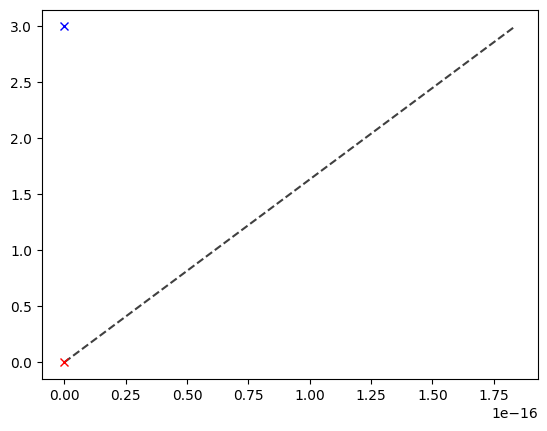

In [9]:
fig = plt.figure()
v = SE2_log(SE2_inv(X0).dot(X1))
p_path = []
for t in np.linspace(0, 1, 10):
    X = X0.dot(SE2_exp(v*t))
    theta, x, y = SE2_to_param(X)
    p_path.append([x, y])
p_path = np.array(p_path)
print(p_path)
plt.plot(p_path[:, 0], p_path[:, 1],  '--k', alpha=0.75)
plt.plot(SE2_to_param(X0)[1], SE2_to_param(X0)[2], 'xr')
plt.plot(SE2_to_param(XS)[1], SE2_to_param(XS)[2], 'xb')

In [10]:
print('Xf', Xf)
print('XS', XS)

kek = Xf-XS
print('Diff ', kek)
print(np.sqrt((kek[0,2])**2 + (kek[1,2])**2))

Xf [[ 6.123234e-17 -1.000000e+00  1.000000e+01]
 [ 1.000000e+00  6.123234e-17  0.000000e+00]
 [ 0.000000e+00  0.000000e+00  1.000000e+00]]
XS [[ 6.123234e-17 -1.000000e+00  0.000000e+00]
 [ 1.000000e+00  6.123234e-17  3.000000e+00]
 [ 0.000000e+00  0.000000e+00  1.000000e+00]]
Diff  [[ 0.  0. 10.]
 [ 0.  0. -3.]
 [ 0.  0.  0.]]
10.44030650891055


In [11]:
print(np.sqrt((10-2)**2 + (0-(-3))**2))

8.54400374531753


In [12]:
V = SE2_inv(X0).dot(X1)
X = X0.dot(V)
theta, x, y = SE2_to_param(X)
print(theta, x, y)

1.5707963267948966 1.8369701987210297e-16 3.0


In [13]:
def coll(collision_points, vehicle_radius, X0, X1, box, steps):
    v = SE2_log(SE2_inv(X0).dot(X1))
    for t in np.linspace(0, 1, steps):
        X = X0.dot(SE2_exp(v*t))
        theta, x, y = SE2_to_param(X)
        # check bounds of environment
        rv = vehicle_radius
        #if (x < box[0] + rv or x > box[1] - rv or y < box[2] + rv or y > box[3] - rv):
            #return True
        for xc, yc, r in collision_points:
            if (xc - x)**2 + (yc - y)**2 < (r + rv)**2:
                return True
    return False

In [14]:
collision_points = np.vstack([[.4, .7], [.1, .5], [.1, .1]]).T
coll(collision_points, .1, X0, X1, box, 5)

False

In [15]:
tilt_up = np.pi/2
tilt_low = 0
th0 = np.pi/6

tvec = np.arange(0, 10, .1)

A = np.abs(tilt_up - tilt_low)
fov_ang = np.deg2rad(10)
h = A/2
tperiod = 10
B = 2*np.pi/tperiod

th_vec = (A/2)*np.sin(B*tvec) + h

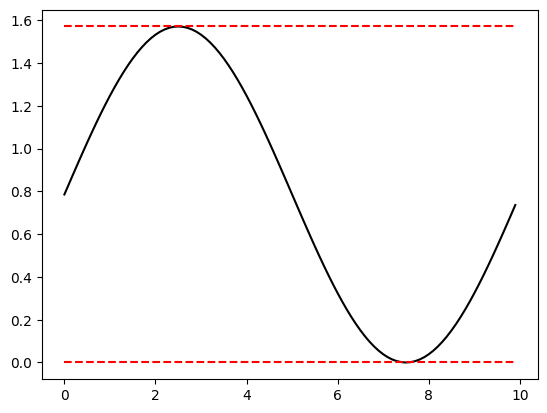

In [16]:
fig = plt.figure()
plt.plot(tvec, th_vec, '-k')
plt.plot(tvec, np.ones((len(tvec),))*tilt_up, '--r')
plt.plot(tvec, np.ones((len(tvec),))*tilt_low, '--r')
plt.show()

In [17]:
Rc = 1

# Camera Location
x0 = np.zeros(len(th_vec),)
y0 = np.zeros(len(th_vec),)

# P1
x1 = x0 + Rc*np.cos(th_vec/2)
y1 = y0 + Rc*np.sin(th_vec/2)

# P2
x2 = x0 + Rc*np.cos(th_vec/2)
y2 = y0 - Rc*np.sin(th_vec/2)

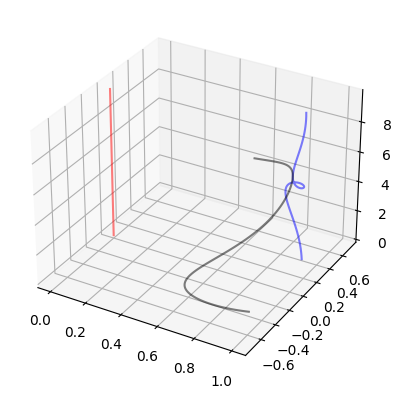

In [18]:
fig = plt.figure()
plt.axes(projection ='3d')
plt.plot(x0, y0, tvec, '-r', alpha = 0.5)
plt.plot(x1, y1, tvec, '-b', alpha = 0.5)
plt.plot(x2, y2, tvec, '-k', alpha = 0.5)
plt.show()

In [19]:
Qnear = SE2_from_param([np.pi/2, 0, 6])
Qnext = SE2_from_param([0, 10, 7])

In [20]:
def local_path_planner(X0, X1, dist):
    """
    Plan a path from X0 to X1. If the norm of the lie algebra
    is greather than 1, limit it to 1.

    @para X0: start
    @param X1: goal
    @dist: the distance to travel
    """
    u, R, d = find_u_R_d(X0, X1)
    print(u, R, d)
    
    print('|R|, ', np.abs(R))
    
    if np.abs(u) > dist:
        u = dist*np.sign(u)    
    if np.abs(R) < 1e-3:
        omega = 0
        #V = SE2_from_param([omega, u, 0])
    else:
        omega = u/R
    v = np.array([omega, u, 0])
    V = SE2_exp(v)
    print('omega', omega)
    print(V)

    return X0.dot(V)

Qroute = local_path_planner(Qnear, Qnext, 20)
print(Qroute)

14.858389510467717 -5.05 10.04987562112089
|R|,  5.05
omega -2.942255348607469
[[ -0.98019802   0.1980198    1.        ]
 [ -0.1980198   -0.98019802 -10.        ]
 [  0.           0.           1.        ]]
[[ 0.1980198   0.98019802 10.        ]
 [-0.98019802  0.1980198   7.        ]
 [ 0.          0.          1.        ]]


[[ 0.          6.        ]
 [ 0.26746423  7.62168171]
 [ 1.04152538  9.07158448]
 [ 2.24018992 10.19612527]
 [ 3.7364876  10.87618552]
 [ 5.37192096 11.03972885]
 [ 6.97325438 10.66943172]
 [ 8.37086434  9.80451837]
 [ 9.416707    8.53660599]
 [10.          7.        ]]


(-0.5, 10.5, 5.748013557431957, 11.291715293928899)

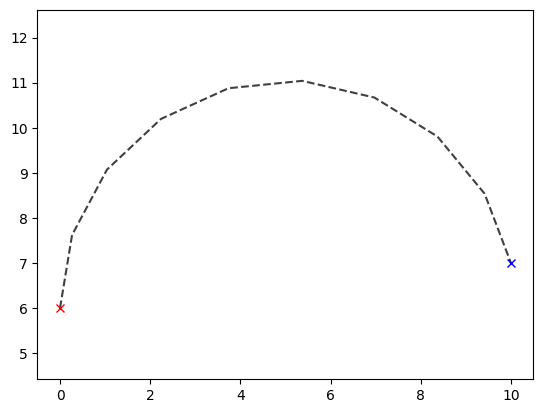

In [21]:
fig = plt.figure()
v = SE2_log(SE2_inv(Qnear).dot(Qroute))
p_path = []
for t in np.linspace(0, 1, 10):
    X = Qnear.dot(SE2_exp(v*t))
    theta, x, y = SE2_to_param(X)
    p_path.append([x, y])
p_path = np.array(p_path)
print(p_path)
plt.plot(p_path[:, 0], p_path[:, 1],  '--k', alpha=0.75)
plt.plot(SE2_to_param(Qnear)[1], SE2_to_param(Qnear)[2], 'xr')
plt.plot(SE2_to_param(Qnext)[1], SE2_to_param(Qnext)[2], 'xb')
plt.axis('equal')

In [22]:
i={'foo':'bar', 'baz':'huh?'}
keys=i.keys()  #in python 3, you'll need `list(i.keys())`
print(keys)
print(list(keys)[1])

values=i.values()
print (keys[values.index("bar")])

dict_keys(['foo', 'baz'])
baz


AttributeError: 'dict_values' object has no attribute 'index'

In [23]:
kek = (['0', '1', '2', '3', '4', '6', '7', '8', '9', '11', '15', '16', '17', '18', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '30', '31', '32', '33', '34', '35'])

In [24]:
print(SE2_to_param(X0))
print(SE2_to_param(Xf))

[1.57079633 0.         0.        ]
[ 1.57079633 10.          0.        ]


In [25]:
X0

array([[ 6.123234e-17, -1.000000e+00,  0.000000e+00],
       [ 1.000000e+00,  6.123234e-17,  0.000000e+00],
       [ 0.000000e+00,  0.000000e+00,  1.000000e+00]])

In [26]:
Xf

array([[ 6.123234e-17, -1.000000e+00,  1.000000e+01],
       [ 1.000000e+00,  6.123234e-17,  0.000000e+00],
       [ 0.000000e+00,  0.000000e+00,  1.000000e+00]])

In [27]:
diff = X0@SE2_inv(Xf)
print(diff)

[[ 1.00000000e+00  0.00000000e+00 -1.00000000e+01]
 [ 0.00000000e+00  1.00000000e+00 -2.46519033e-32]
 [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]


In [28]:
np.sqrt(diff[0,2]**2 + diff[1,2]**2)

10.0

In [41]:
from sympy import *

In [42]:
x = 1
y = symbols('y')
eq = Eq((x)**2 + (y)**2, 4)

sol = solve(eq)
print(sol)

[-sqrt(3), sqrt(3)]


In [44]:
kek = N(sol[1])
print(kek)

1.73205080756888


In [48]:
import random as rn

In [68]:
vmax = 1.5
ti = 1
tf = 10
x0 = (0,0)
xf = (10,0)
xi = (1.5,0)

In [59]:
r = ti*vmax
x = rn.uniform(-r, r)
y = symbols('y')
eq = Eq((x-xf[0])**2+(y-xf[1])**2+(y-xi[0])**2+(y-xi[1])**2, tf**2 + vmax**2)
sol = solve(eq)
print(N(sol[0])

[-0.0346975164043374, 1.03469751640434]


In [71]:
# Check intersection
x = symbols('x')
y = symbols('y')
eq1 = Eq((x-xf[0])**2+(y-xf[1])**2, ((tf-ti)*vmax)**2)
eq2 = Eq((y-xi[0])**2+(y-xi[1])**2, (ti*vmax)**2)
sol = solve((eq1, eq2), (x, y))
print(sol)

[(-3.50000000000000, 0.0), (-3.41640786499874, 1.50000000000000), (23.4164078649987, 1.50000000000000), (23.5000000000000, 0.0)]


(-4.842863488281649,
 24.84966016610865,
 -14.848130795957045,
 14.848130795957045)

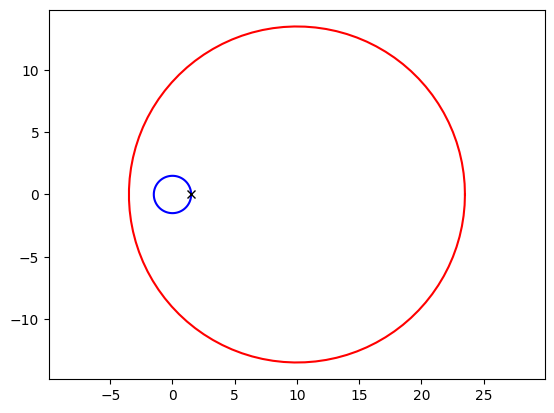

In [80]:
fig = plt.figure()
ang_vec = np.linspace(0, 2*np.pi, 100)
r1x = ((tf-ti)*vmax)*np.cos(ang_vec)
r1y = ((tf-ti)*vmax)*np.sin(ang_vec)
r2x = (ti*vmax)*np.cos(ang_vec)
r2y = (ti*vmax)*np.sin(ang_vec)
plt.plot(r1x+xf[0], r1y+xf[1], '-r')
plt.plot(r2x+x0[0], r2y+x0[1], '-b')
plt.plot(xi[0], xi[1], 'xk')
plt.axis('equal')

In [77]:
from shapely.geometry import Polygon

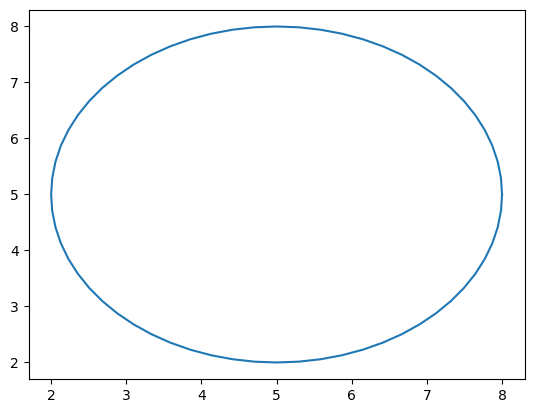

In [82]:
from shapely.geometry import Point
 
circle = Point(5, 5).buffer(3)

fig = plt.figure()
plt.plot(*circle.exterior.xy)